<a href="https://colab.research.google.com/github/DavideSecoli/Machine-Learning-/blob/master/Alpha_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install quandl

In [2]:
import pandas as pd
pd.core.common.is_list_like = pd.api.types.is_list_like # may be necessary in some versions of pandas
import pandas_datareader.data as web
import quandl
import numpy as np

import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import display

from scipy.cluster import hierarchy
from scipy.spatial import distance

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PowerTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,Normalizer

/usr/local/lib/python3.6/dist-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [0]:
# API call for oil
my_key = "cDYJfjFo6xwsn3xZjW58" 

In [0]:
# function to get symbols data
def get_symbols(symbols,data_source, begin_date=None,end_date=None):
    out = pd.DataFrame()
    for symbol in symbols:
        df = web.DataReader(symbol, data_source,begin_date, end_date,api_key=my_key)\
        [['AdjOpen','AdjHigh','AdjLow','AdjClose','AdjVolume']].reset_index()
        df.columns = ['date','open','high','low','close','volume'] #my convention: always lowercase
        df['symbol'] = symbol # add a new column which contains the symbol so we can keep multiple symbols in the same dataframe
        df = df.set_index(['date','symbol'])
        out = pd.concat([out,df],axis=0) #stacks on top of previously collected data
    return out.sort_index()
    
prices = get_symbols(['AAPL','CSCO'],data_source='quandl',\
                     begin_date='2000-01-01',end_date='2017-01-01')

In [5]:
print(prices.shape)
prices.tail(15)

(8554, 5)


open        high         low       close      volume
date       symbol                                                            
2016-12-20 CSCO     29.764947   29.803565   29.402902   29.504275  17475171.0
2016-12-21 AAPL    115.357349  115.949938  115.337596  115.614138  23783165.0
           CSCO     29.629784   29.629784   29.359457   29.369111  14488949.0
2016-12-22 AAPL    114.912908  115.070931  114.211677  114.853649  26085854.0
           CSCO     29.349802   29.427038   29.204984   29.407729  12935767.0
2016-12-23 AAPL    114.162295  115.080808  114.162295  115.080808  14249484.0
           CSCO     29.484966   29.542893   29.349802   29.475311   9167598.0
2016-12-27 AAPL    115.080808  116.344998  115.051178  115.811668  18296855.0
           CSCO     29.581511   29.755293   29.542893   29.620129  14175488.0
2016-12-28 AAPL    116.068456  116.558923  114.764760  115.317843  20905892.0
           CSCO     29.639438   29.707020   29.301529   29.369111  12022231.0
2016-12-29 AAPL    115.011672  115.663027  114.962290  115.288214  15039519.0
           CSCO     29.320838   29.494620   29.282220   29.407729  10995584.0
2016-12-30 AAPL    115.209202  115.752409  114.004271  114.389454  30586265.0
           CSCO     29.504275   29.542893   29.089130   29.176020  20190029.0

### **Feature** **engineering**

(8114, 31)


o         h         l  ...       f25  f26  f27
date       symbol                                 ...                    
2000-10-17 AAPL     1.393734  0.343446  0.235246  ... -3.192555 -1.0 -1.0
           CSCO    45.814233  3.834645  3.786730  ... -1.428730  1.0 -1.0
2000-10-18 AAPL     1.249155  0.302510  0.186329  ... -3.099495  1.0  1.0
           CSCO    43.591284  3.812436  3.721316  ... -1.815778  1.0 -1.0
2000-10-19 AAPL     1.231164  0.241322  0.162582  ... -3.116813  1.0 -1.0

[5 rows x 31 columns]

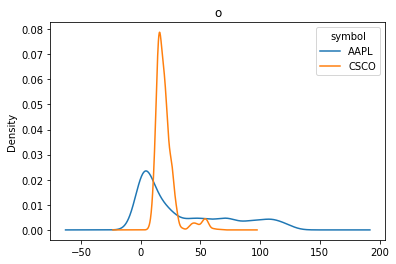

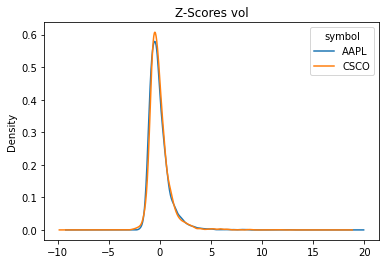

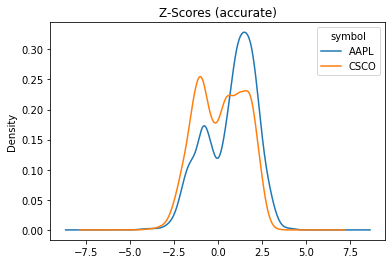

In [6]:
features = pd.DataFrame(index=prices.index)

# open
features['o'] = prices.open
features.o.unstack().plot.kde(title='o')

# high
features['h'] = prices.high.apply(np.log) 

# low
features['l'] = prices.low.apply(np.log) 

# close
features['c'] = prices.close.apply(np.log)


# open gap 
features['f01'] = prices.open/prices.groupby(level='symbol').close.shift(1)-1
features['f01'].iloc[:2] = features['f01'].mean() # fill nan with mean

# intraday move 
features['f02'] = (prices.groupby(level='symbol').close\
                   .shift(0) - prices.groupby(level='symbol').open\
                   .shift(0))/prices.groupby(level='symbol').open.shift(0)

# daily returns 
features['f03'] = (prices.groupby(level='symbol').close\
                   .shift(0) - prices.groupby(level='symbol').open\
                   .shift(0))/prices.groupby(level='symbol').close.shift(1)

# 50 day exponential moving avg
ema_50 = lambda x: x.ewm(span=50).mean()
features['f04'] = prices.close.groupby(level='symbol').apply(ema_50)-1

# 100 day exponential moving avg
ema_100 = lambda x: x.ewm(span=100).mean()
features['f05'] = prices.close.groupby(level='symbol').apply(ema_100)-1

# 200 day exponential moving avg
ema_200 = lambda x: x.ewm(span=200).mean()
features['f06'] = prices.close.groupby(level='symbol').apply(ema_200)-1

# daily closing price vs. 50 day exponential moving avg
ema_50 = lambda x: x.ewm(span=50).mean()
features['f07'] = prices.close/ prices.close.groupby(level='symbol').apply(ema_50)-1

# daily closing price vs. 100 day exponential moving avg
ema_100 = lambda x: x.ewm(span=100).mean()
features['f08'] = prices.close/ prices.close.groupby(level='symbol').apply(ema_100)-1

# daily closing price vs. 200 day exponential moving avg
ema_200 = lambda x: x.ewm(span=200).mean()
features['f09'] = prices.close/ prices.close.groupby(level='symbol').apply(ema_200)-1

# VOLUME 

# log of daily volume
features['f10'] = prices.volume.groupby(level='symbol').apply(np.log)

# log daily vol diff
features['f11'] = features['f10'].diff()

# 5 day log daily vol diff
features['f12'] = features['f10'].diff(5)

# 10 day log daily vol diff
features['f13'] = features['f10'].diff(10)

# 20 day log daily vol diff
features['f14'] = features['f10'].diff(20)

# 50 day log daily vol diff
features['f15'] = features['f10'].diff(50)

# 100 day log daily vol diff
features['f16'] = features['f10'].diff(100)

# 200 day log daily vol diff
features['f17'] = features['f10'].diff(200)

# volume perc change
pct_chg_fxn = lambda x: x.pct_change()
features['f18'] = prices.groupby(level='symbol').volume.apply(pct_chg_fxn) 

# log of 5 day moving average of volume
ma_5 = lambda x: x.rolling(5).mean()
features['f19'] = prices.volume.groupby(level='symbol').apply(ma_5).apply(np.log) 


# log of 10 day moving average of volume
ma_10 = lambda x: x.rolling(10).mean()
features['f20'] = prices.volume.groupby(level='symbol').apply(ma_10).apply(np.log) 

# log of 20 day moving average of volume
ma_20 = lambda x: x.rolling(20).mean()
features['f21'] = prices.volume.groupby(level='symbol').apply(ma_20).apply(np.log) 

# log of 50 day moving average of volume
ma_50 = lambda x: x.rolling(50).mean()
features['f22'] = prices.volume.groupby(level='symbol').apply(ma_50).apply(np.log) 

# log of 100 day moving average of volume
ma_100 = lambda x: x.rolling(5).mean()
features['f22'] = prices.volume.groupby(level='symbol').apply(ma_100).apply(np.log) 

# daily volume vs. 200 day moving average
ma_200 = lambda x: x.rolling(200).mean()
features['f23'] = prices.volume/ prices.volume.groupby(level='symbol').apply(ma_200)-1

# z-score vol
zscore_improved = lambda x: (x - x.rolling(window=200, min_periods=20).mean())\
/ x.rolling(window=200, min_periods=20).std()
features['f24'] =prices.groupby(level='symbol').volume.apply(zscore_improved)
features.f24.unstack().plot.kde(title='Z-Scores vol')

# z-score score
zscore_improved = lambda x: (x - x.rolling(window=200, min_periods=20).mean())\
/ x.rolling(window=200, min_periods=20).std()
features['f25'] =prices.groupby(level='symbol').close.apply(zscore_improved)
features.f25.unstack().plot.kde(title='Z-Scores (accurate)')

# + - signing for volume 
features['f26'] = features['f18'].apply(np.sign)

# + - signing for close
features['f27'] = features['f03'].apply(np.sign)

# cumsum vol days up/down
#sign = features['f26'] >=0
#features['f26a'] = features['f26'].groupby((sign != sign.shift()).cumsum()).cumsum()

# number of up-days minus the number of down days (can be applied to close prices as well) 
#plus_minus_fxn = lambda x: x.rolling(20).sum()
#features['f28'] = features['f03'].groupby(level='symbol').apply(plus_minus_fxn)
#features['f28'].iloc[:38] = features['f28'].mean() # fill nan with mean

# day of week
#features['day_of_week'] = features.index.get_level_values('date').weekday

# day of month 
#features['day_of_month'] = features.index.get_level_values('date').day

# eliminate first 400 to get rid of NaNs 
features = features.iloc[400:]

# eliminate last 40 rows to have same shape of oucomes
features = features.iloc[:-40]
print(features.shape)
features.isnull().values.any()
features.head()

In [7]:
for nan in features.columns:
  print(nan, features[nan].isnull().sum())

o 0
h 0
l 0
c 0
f01 0
f02 0
f03 0
f04 0
f05 0
f06 0
f07 0
f08 0
f09 0
f10 0
f11 0
f12 0
f13 0
f14 0
f15 0
f16 0
f17 0
f18 0
f19 0
f20 0
f21 0
f22 0
f23 0
f24 0
f25 0
f26 0
f27 0


### **One**-**hot** **encoding** 

In [8]:
month_of_year = prices.index.get_level_values(level='date').month
one_hot_frame = pd.DataFrame(pd.get_dummies(month_of_year))
one_hot_frame.index = prices.index # Careful!  This is forcing index values without usual pandas alignments!

# create column names 
begin_num = int(features.columns[-1][-2:]) + 1 #first available feature
#begin_num = len(features.columns) + 1
feat_names = ['f'+str(num) for num in list(range(begin_num,begin_num+12,1))]

# rename columns and merge
one_hot_frame.columns = feat_names
tot_features = features.join(one_hot_frame)
print(tot_features.iloc[:,-12:].tail())
tot_features.shape

                   f28  f29  f30  f31  f32  f33  f34  f35  f36  f37  f38  f39
date       symbol                                                            
2016-11-29 CSCO      0    0    0    0    0    0    0    0    0    0    1    0
2016-11-30 AAPL      0    0    0    0    0    0    0    0    0    0    1    0
           CSCO      0    0    0    0    0    0    0    0    0    0    1    0
2016-12-01 AAPL      0    0    0    0    0    0    0    0    0    0    0    1
           CSCO      0    0    0    0    0    0    0    0    0    0    0    1


(8114, 43)

In [9]:
day_of_month = prices.index.get_level_values(level='date').day
one_hot_frame = pd.DataFrame(pd.get_dummies(day_of_month))
one_hot_frame.index = prices.index # Careful!  This is forcing index values without usual pandas alignments!

# create column names 
#begin_num = int(features.columns[-1][-2:]) + 1 #first available feature
begin_num = len(tot_features.columns) + 1
feat_names = ['f'+str(num) for num in list(range(begin_num,begin_num+31,1))]

# rename columns and merge
one_hot_frame.columns = feat_names
tot_features = tot_features.join(one_hot_frame)
print(tot_features.iloc[:,-31:].tail())

                   f44  f45  f46  f47  f48  f49  ...  f69  f70  f71  f72  f73  f74
date       symbol                                ...                              
2016-11-29 CSCO      0    0    0    0    0    0  ...    0    0    0    1    0    0
2016-11-30 AAPL      0    0    0    0    0    0  ...    0    0    0    0    1    0
           CSCO      0    0    0    0    0    0  ...    0    0    0    0    1    0
2016-12-01 AAPL      1    0    0    0    0    0  ...    0    0    0    0    0    0
           CSCO      1    0    0    0    0    0  ...    0    0    0    0    0    0

[5 rows x 31 columns]


In [10]:
print(tot_features.shape)
tot_features.isnull().sum()
tot_features.head(15)


(8114, 74)


o         h         l         c  ...  f71  f72  f73  f74
date       symbol                                           ...                    
2000-10-17 AAPL     1.393734  0.343446  0.235246  0.256849  ...    0    0    0    0
           CSCO    45.814233  3.834645  3.786730  3.808594  ...    0    0    0    0
2000-10-18 AAPL     1.249155  0.302510  0.186329  0.256849  ...    0    0    0    0
           CSCO    43.591284  3.812436  3.721316  3.765333  ...    0    0    0    0
2000-10-19 AAPL     1.231164  0.241322  0.162582  0.196411  ...    0    0    0    0
           CSCO    45.500210  3.889032  3.802896  3.874038  ...    0    0    0    0
2000-10-20 AAPL     1.224738  0.269198  0.196411  0.225549  ...    0    0    0    0
           CSCO    47.623994  3.894261  3.847949  3.857769  ...    0    0    0    0
2000-10-23 AAPL     1.302489  0.278482  0.222468  0.269198  ...    0    0    0    0
           CSCO    46.483596  3.865417  3.815535  3.832500  ...    0    0    0    0
2000-10-24 AAPL     1.329477  0.293448  0.189524  0.192708  ...    0    0    0    0
           CSCO    46.739773  3.856721  3.799388  3.814442  ...    0    0    0    0
2000-10-25 AAPL     1.224738  0.209524  0.169657  0.172906  ...    0    0    0    0
           CSCO    42.607897  3.790096  3.731267  3.733838  ...    0    0    0    0
2000-10-26 AAPL     1.208674  0.192708  0.117336  0.172906  ...    0    0    0    0

[15 rows x 74 columns]

### **Outcomes** **table** (**y**)

In [11]:
outcomes = pd.DataFrame(index=prices.index)

# next day's closing change
func_one_day_ahead = lambda x: x.pct_change(-1)
outcomes['close_1'] = prices.groupby(level='symbol').close.apply(func_one_day_ahead)

# 3 day closing change 
func_three_day_ahead = lambda x: x.pct_change(-3)
outcomes['close_3'] = prices.groupby(level='symbol').close.apply(func_three_day_ahead)

# 5 day closing change 
func_five_day_ahead = lambda x: x.pct_change(-5)
outcomes['close_5'] = prices.groupby(level='symbol').close.apply(func_five_day_ahead)

# 5 day closing change 
func_twenty_day_ahead = lambda x: x.pct_change(-20)
outcomes['close_20'] = prices.groupby(level='symbol').close.apply(func_twenty_day_ahead)

# elimitate first 400 to align with tot_features 
outcomes = outcomes.iloc[400:]

# eliminate last 40 row to get rid of NaNs
outcomes = outcomes.iloc[:-40]
print(outcomes.shape)
outcomes.isnull().sum()
outcomes.tail()

(8114, 4)


close_1   close_3   close_5  close_20
date       symbol                                        
2016-11-29 CSCO    0.000335  0.019829  0.017047 -0.019395
2016-11-30 AAPL    0.009407  0.012923 -0.004593 -0.053200
           CSCO    0.012564  0.009821 -0.004341 -0.021011
2016-12-01 AAPL   -0.003731 -0.004184 -0.023457 -0.054654
           CSCO    0.006838  0.004091 -0.016694 -0.025480

### **Test** **train** **split**

In [12]:
length_split = int(len(tot_features) * 0.66)

X_train = tot_features.iloc[:length_split,:]
X_test = tot_features.iloc[length_split:,:]
y_train = outcomes.iloc[:length_split,:]
y_test = outcomes.iloc[length_split:,:]


print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)
X_train.head()

(5355, 74)
(2759, 74)
(5355, 4)
(2759, 4)


o         h         l         c  ...  f71  f72  f73  f74
date       symbol                                           ...                    
2000-10-17 AAPL     1.393734  0.343446  0.235246  0.256849  ...    0    0    0    0
           CSCO    45.814233  3.834645  3.786730  3.808594  ...    0    0    0    0
2000-10-18 AAPL     1.249155  0.302510  0.186329  0.256849  ...    0    0    0    0
           CSCO    43.591284  3.812436  3.721316  3.765333  ...    0    0    0    0
2000-10-19 AAPL     1.231164  0.241322  0.162582  0.196411  ...    0    0    0    0

[5 rows x 74 columns]

### **Feature** **selection**

In [13]:
# standardise X_train data
X_scaler = PowerTransformer()
X_train_scaled = X_scaler.fit_transform(X_train.iloc[:,:29])
X_train_scaled = pd.DataFrame(X_train_scaled, index=X_train.index)
X_train_scaled.columns = X_train.iloc[:,:29].columns
X_train_scaled = pd.concat([X_train_scaled,X_train.iloc[:,29:]],axis=1)

# standardise X_test data 
X_test_scaled = X_scaler.transform(X_test.iloc[:,:29])
X_test_scaled = pd.DataFrame(X_test_scaled, index=X_test.index)
X_test_scaled.columns = X_test.iloc[:,:29].columns
X_test_scaled = pd.concat([X_test_scaled,X_test.iloc[:,29:]],axis=1)

# standardise y_train data 
y_scaler = PowerTransformer()
y_train_scaled = y_scaler.fit_transform(y_train)
y_train_scaled = pd.DataFrame(y_train_scaled, index=y_train.index)
y_train_scaled.columns = y_train.columns

# standardise X_test data 
y_test_scaled = y_scaler.transform(y_test)
y_test_scaled = pd.DataFrame(y_test_scaled, index=y_test.index)
y_test_scaled.columns = y_test.columns

y_test_scaled.iloc[:,2:3]

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:2982: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


close_5
date       symbol          
2011-06-10 CSCO    0.239312
2011-06-13 AAPL    0.657339
           CSCO   -0.020742
2011-06-14 AAPL    0.435909
           CSCO   -0.418577
...                     ...
2016-11-29 CSCO    0.355760
2016-11-30 AAPL   -0.008811
           CSCO   -0.004449
2016-12-01 AAPL   -0.341392
           CSCO   -0.220551

[2759 rows x 1 columns]

In [0]:
# create separate y_test df for later use

y_train_scaled_1 = y_train_scaled.iloc[:,:1]
y_train_scaled_3 = y_train_scaled.iloc[:,1:2]
y_train_scaled_5 = y_train_scaled.iloc[:,2:3]
y_train_scaled_20 = y_train_scaled.iloc[:,3:4]

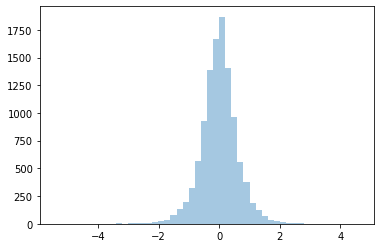

In [15]:
sns.distplot(y_test_scaled, kde=False);

In [16]:
X_test_scaled.o.max()

6.257371829726652

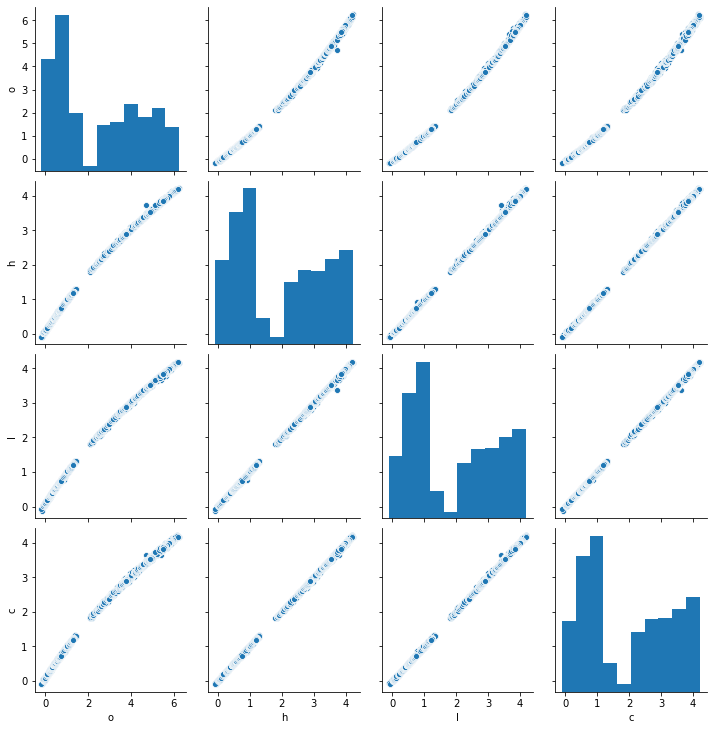

In [17]:
# not normally distributed: o, h, l, c, f04, f05, f06, 

sns.pairplot(X_test_scaled.iloc[:,:4])

In [18]:
# correlations of test sample features with all outcomes 
tot_corr = pd.concat([X_test_scaled.iloc[:,29:],y_test_scaled],axis=1).corr().iloc[:-4,-4:]

# sliced correlations of sigular outcome 
corr_close_1 = tot_corr.iloc[:,0]
corr_close_3 = tot_corr.iloc[:,1]
corr_close_5 = tot_corr.iloc[:,2]
corr_close_20 = tot_corr.iloc[:,3]

tot_corr.tail()

,close_1,close_3,close_5,close_20
f70,-0.001651,0.008913,-0.000023,0.007661
f71,-0.005721,0.001012,0.023333,0.010137
f72,-0.000976,0.010774,0.012045,-0.011666
f73,0.000148,0.015996,-0.008398,-0.020823
f74,0.025917,0.013898,0.009301,0.026908


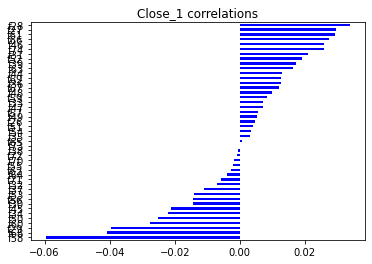

In [19]:
corr_close_1.sort_values().plot.barh(color = 'blue',title = 'Close_1 correlations')

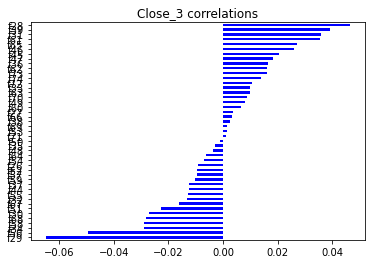

In [20]:
corr_close_3.sort_values().plot.barh(color = 'blue',title = 'Close_3 correlations')

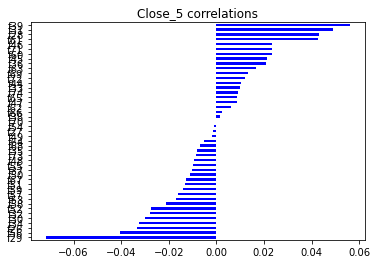

In [21]:
corr_close_5.sort_values().plot.barh(color = 'blue',title = 'Close_5 correlations')

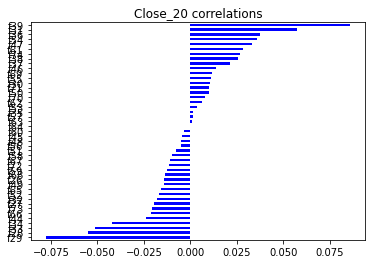

In [22]:
corr_close_20.sort_values().plot.barh(color = 'blue',title = 'Close_20 correlations')

In [23]:
X_train_scaled.min()

o      -1.727618
h      -1.846688
l      -1.847334
c      -1.844701
f01   -11.194979
         ...    
f70     0.000000
f71     0.000000
f72     0.000000
f73     0.000000
f74     0.000000
Length: 74, dtype: float64

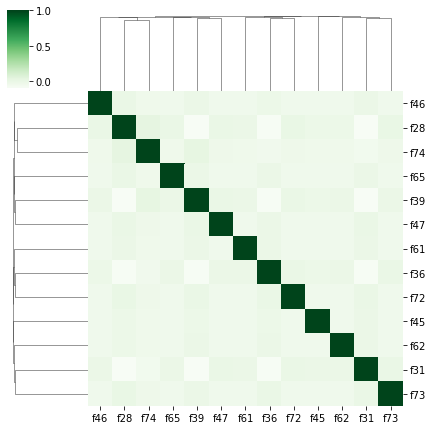

Correlation Strength of Close_3:
f28    0.046544
f39    0.039213
f31    0.035862
f61    0.035442
f65    0.027138
f46    0.025904
f45    0.020437
f47    0.018419
f36    0.016360
f62    0.016018
f73    0.015996
f74    0.013898
f72    0.010774
Name: close_3, dtype: float64


In [24]:
# CLose_3 correlations using train set
correlated_features = corr_close_3[corr_close_3>0.01].index.tolist()
corr_matrix = X_train_scaled[correlated_features].corr()
correlations_array = np.asarray(corr_matrix)

linkage = hierarchy.linkage(distance.pdist(correlations_array), \
                            method='average')

g = sns.clustermap(corr_matrix,row_linkage=linkage,col_linkage=linkage,\
                   row_cluster=True,col_cluster=True,figsize=(6,6),cmap='Greens')
plt.setp(g.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
plt.show()

label_order = corr_matrix.iloc[:,g.dendrogram_row.reordered_ind].columns
print("Correlation Strength of Close_3:")
print(corr_close_3[corr_close_3>0.01].sort_values(ascending=False))

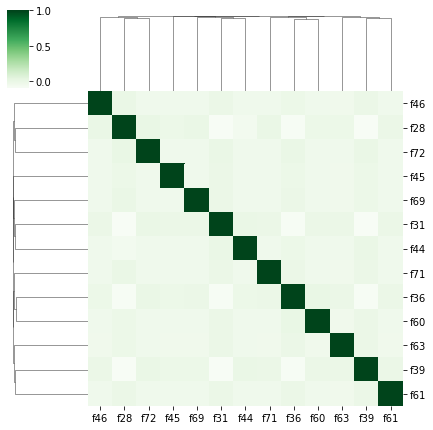

Correlation Strength of Close_5:
f39    0.056246
f31    0.048937
f28    0.042985
f61    0.042737
f46    0.023530
f71    0.023333
f60    0.023268
f45    0.021240
f36    0.020867
f63    0.016586
f69    0.013214
f72    0.012045
f44    0.010250
Name: close_5, dtype: float64


In [25]:
# Close_5 correlations using train set 
correlated_features = corr_close_5[corr_close_5>0.01].index.tolist()
corr_matrix = X_train_scaled[correlated_features].corr()
correlations_array = np.asarray(corr_matrix)

linkage = hierarchy.linkage(distance.pdist(correlations_array), \
                            method='average')

g = sns.clustermap(corr_matrix,row_linkage=linkage,col_linkage=linkage,\
                   row_cluster=True,col_cluster=True,figsize=(6,6),cmap='Greens')
plt.setp(g.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
plt.show()

label_order = corr_matrix.iloc[:,g.dendrogram_row.reordered_ind].columns
print("Correlation Strength of Close_5:")
print(corr_close_5[corr_close_5>0.01].sort_values(ascending=False))

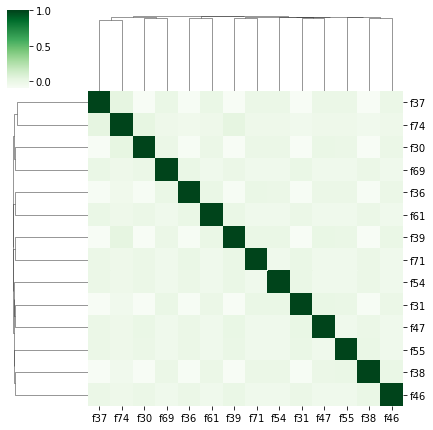

Correlation Strength of Close_20:
f39    0.086056
f31    0.057413
f36    0.037609
f54    0.036053
f47    0.033283
f61    0.028588
f74    0.026908
f38    0.025406
f37    0.021244
f46    0.013961
f69    0.011630
f55    0.011388
f30    0.010743
f71    0.010137
Name: close_20, dtype: float64


In [26]:
# Close_20 correlations using train set 
correlated_features = corr_close_20[corr_close_20>0.01].index.tolist()
corr_matrix = X_train_scaled[correlated_features].corr()
correlations_array = np.asarray(corr_matrix)

linkage = hierarchy.linkage(distance.pdist(correlations_array), \
                            method='average')

g = sns.clustermap(corr_matrix,row_linkage=linkage,col_linkage=linkage,\
                   row_cluster=True,col_cluster=True,figsize=(6,6),cmap='Greens')
plt.setp(g.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
plt.show()

label_order = corr_matrix.iloc[:,g.dendrogram_row.reordered_ind].columns
print("Correlation Strength of Close_20:")
print(corr_close_20[corr_close_20>0.01].sort_values(ascending=False))

####**Features** **correlations** **to** **Close** **1**

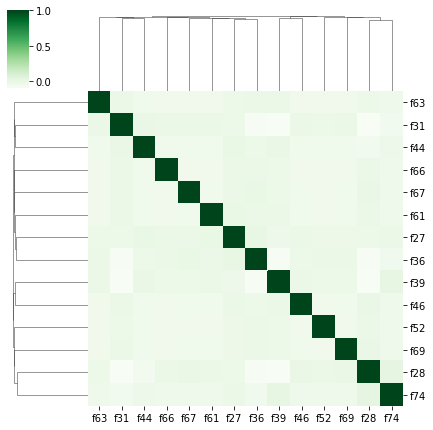

Correlation Strength of Close_1:
f28    0.033941
f27    0.029452
f61    0.029238
f66    0.027401
f46    0.025973
f74    0.025917
f31    0.021008
f52    0.019164
f39    0.017444
f63    0.016284
f44    0.013062
f69    0.012675
f36    0.012543
f67    0.011944
Name: close_1, dtype: float64


In [27]:
# Close_1 correlations using train set
correlated_features = corr_close_1[corr_close_1>0.01].index.tolist()
corr_matrix = X_train_scaled[correlated_features].corr()
correlations_array = np.asarray(corr_matrix)

linkage = hierarchy.linkage(distance.pdist(correlations_array), \
                            method='average')

g = sns.clustermap(corr_matrix,row_linkage=linkage,col_linkage=linkage,\
                   row_cluster=True,col_cluster=True,figsize=(6,6),cmap='Greens')
plt.setp(g.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
plt.show()

label_order = corr_matrix.iloc[:,g.dendrogram_row.reordered_ind].columns
corr_1_sorted = corr_close_1[corr_close_1>0.01].sort_values(ascending=False)
print("Correlation Strength of Close_1:")
print(corr_1_sorted)

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:2071: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


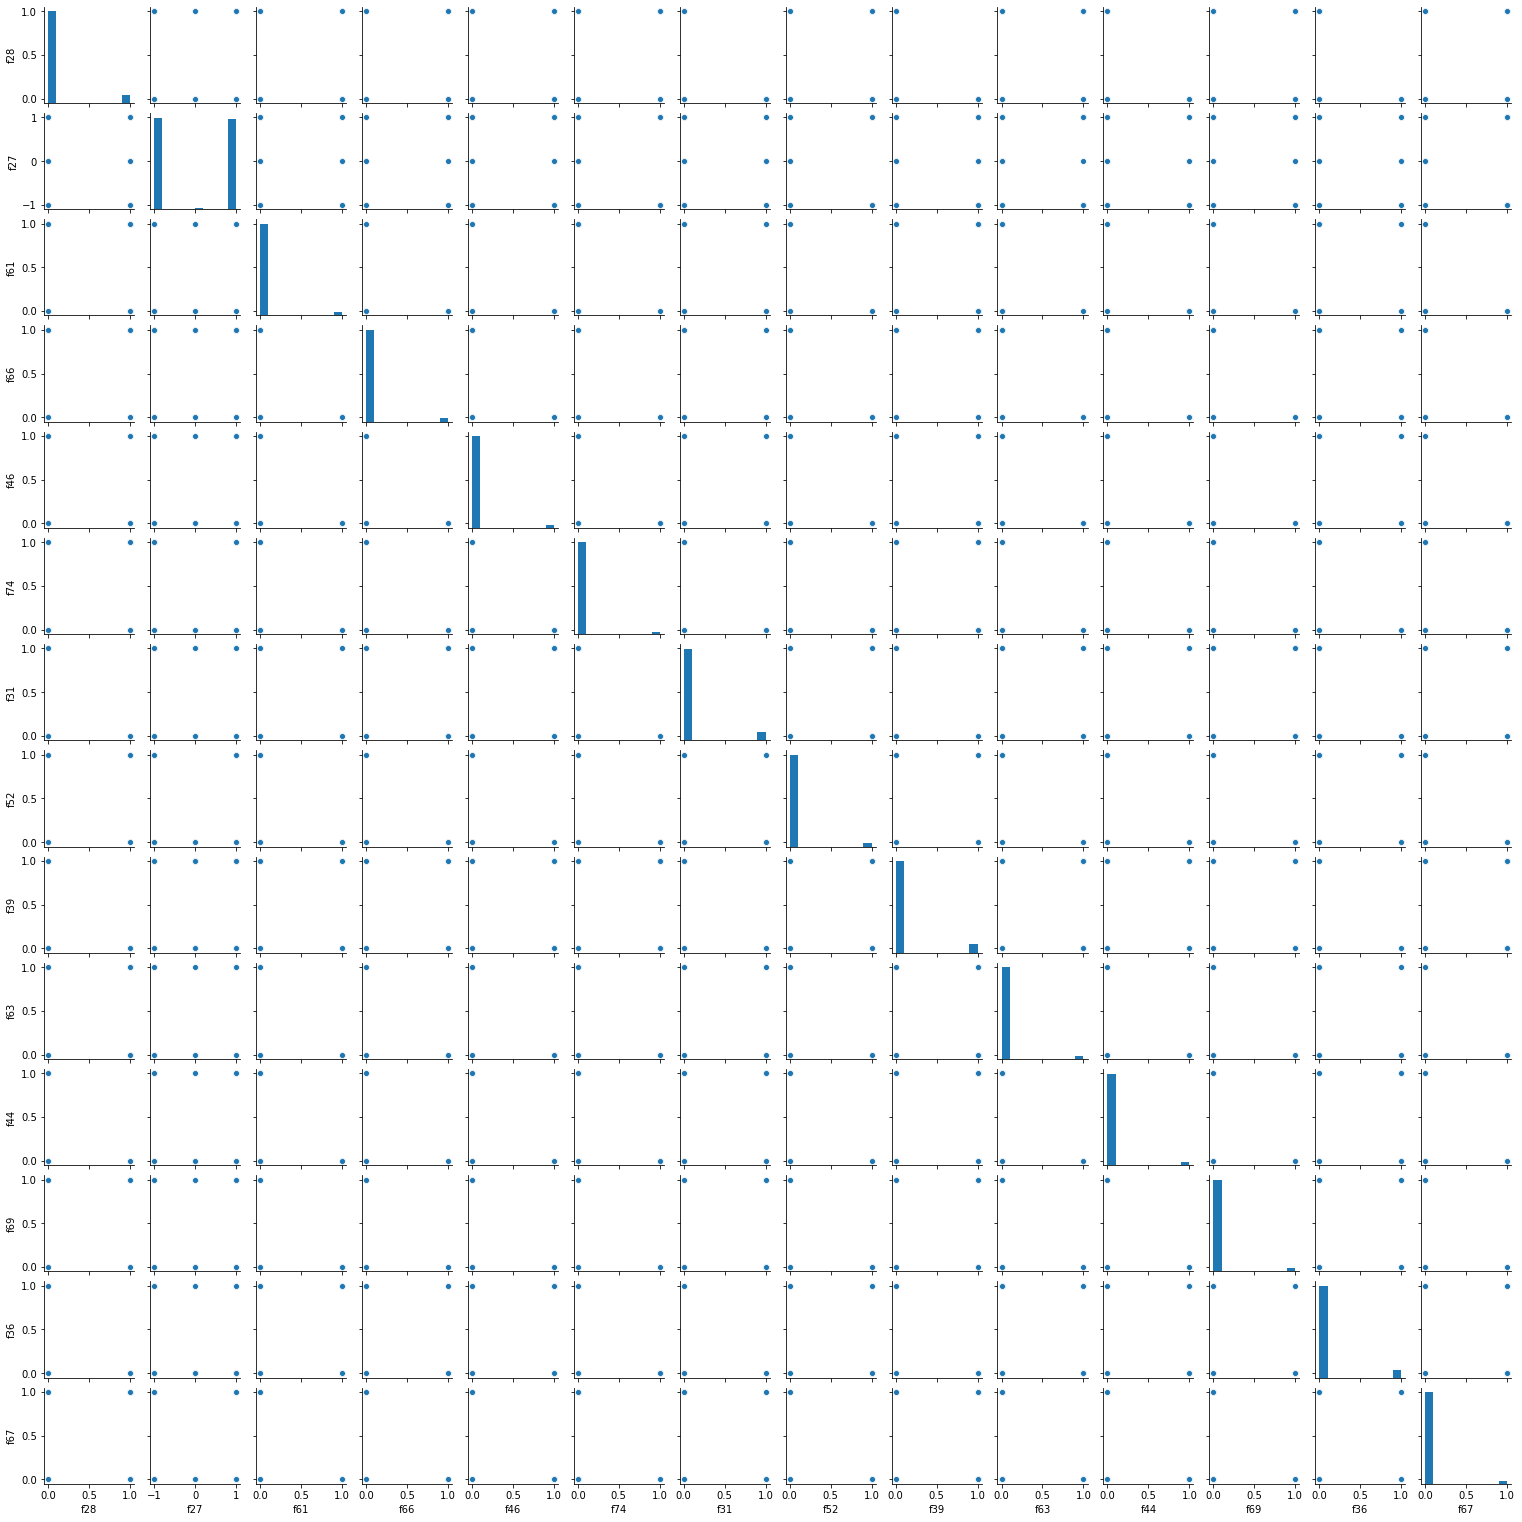

In [28]:
# pair plot of close_1

import seaborn as sns
sns.pairplot(X_train_scaled[corr_1_sorted.index],size=1.5)

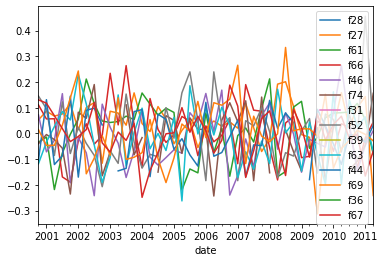

In [29]:
corr_overtime_close_1 = X_train_scaled[corr_1_sorted.index].join(y_train_scaled_1).reset_index().set_index('date')

# close 1 features quarter correlations over time
corr_overtime_close_1[corr_1_sorted.index].dropna().resample('Q').apply(lambda x: x.corr(corr_overtime_close_1['close_1'])).plot()

####**Features** **correlations** **to** **Close** **20**

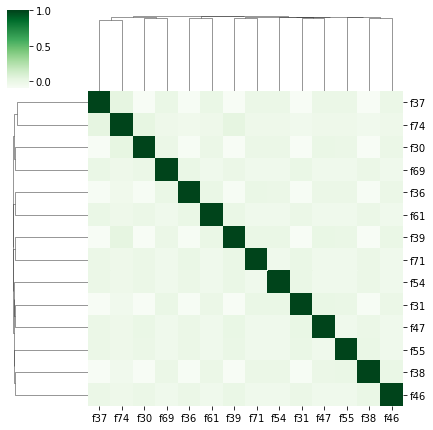

Correlation Strength of Close_20:
f39    0.086056
f31    0.057413
f36    0.037609
f54    0.036053
f47    0.033283
f61    0.028588
f74    0.026908
f38    0.025406
f37    0.021244
f46    0.013961
f69    0.011630
f55    0.011388
f30    0.010743
f71    0.010137
Name: close_20, dtype: float64


In [31]:
correlated_features = corr_close_20[corr_close_20>0.01].index.tolist()
corr_matrix = X_train_scaled[correlated_features].corr()
correlations_array = np.asarray(corr_matrix)

linkage = hierarchy.linkage(distance.pdist(correlations_array), \
                            method='average')

g = sns.clustermap(corr_matrix,row_linkage=linkage,col_linkage=linkage,\
                   row_cluster=True,col_cluster=True,figsize=(6,6),cmap='Greens')
plt.setp(g.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
plt.show()

corr_20_sorted = corr_close_20[corr_close_20>0.01].sort_values(ascending=False)
print("Correlation Strength of Close_20:")
print(corr_20_sorted)

In [0]:
# create X_train using close_20 best features 

X_train_scaled_20 = X_train_scaled[corr_20_sorted.index]

In [33]:
list(corr_20_sorted.index)

['f39',
 'f31',
 'f36',
 'f54',
 'f47',
 'f61',
 'f74',
 'f38',
 'f37',
 'f46',
 'f69',
 'f55',
 'f30',
 'f71']

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:2071: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


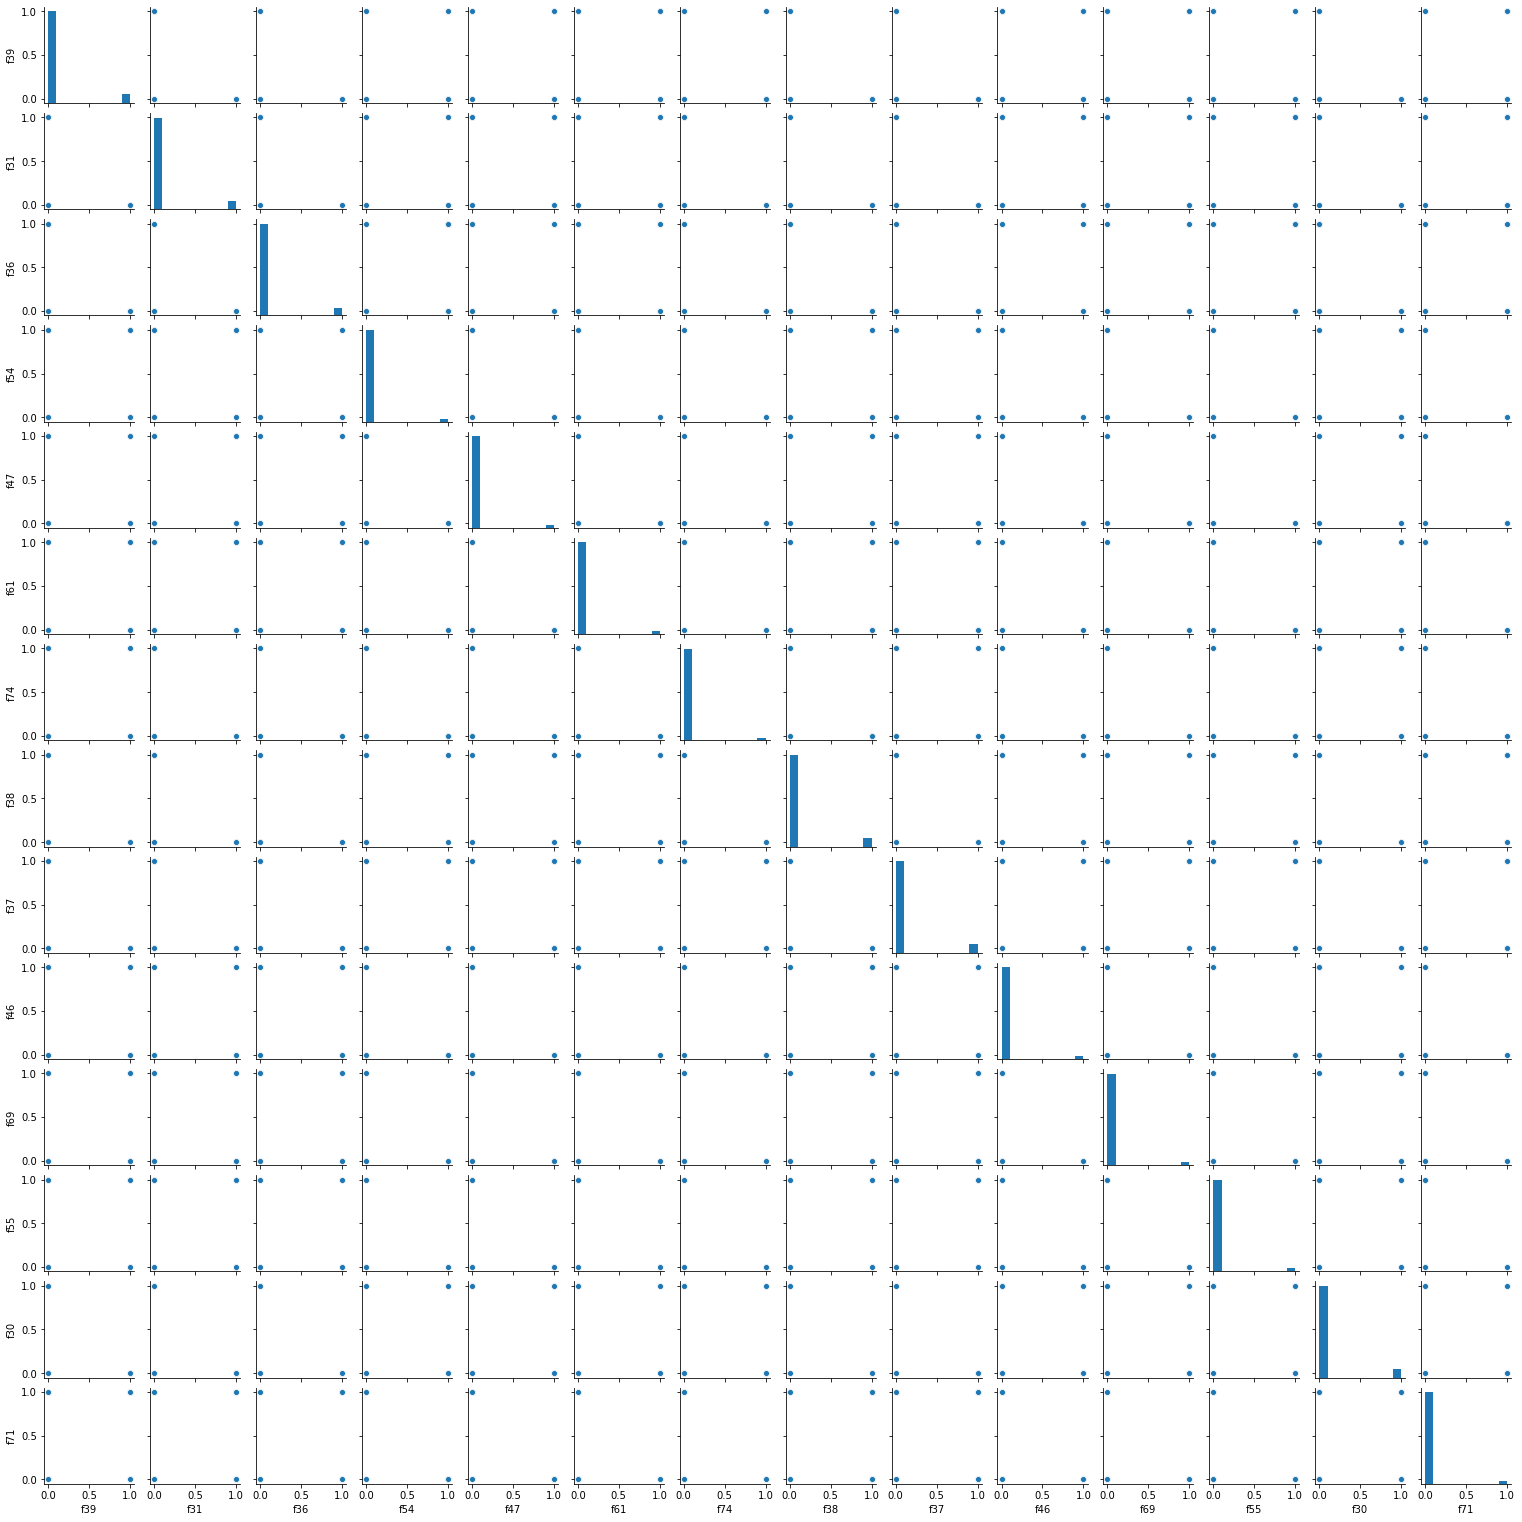

In [34]:
# pair plot of close_20

import seaborn as sns
sns.pairplot(X_train_scaled_20,size=1.5)

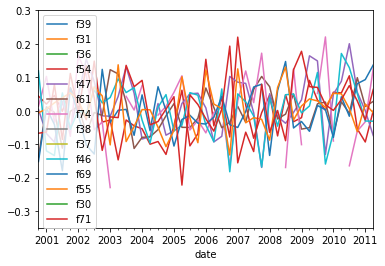

In [35]:
corr_overtime_close_20 = X_train_scaled[corr_20_sorted.index].join(y_train_scaled_20).reset_index().set_index('date')

# close 20 features quarter correlations over time
corr_overtime_close_20[corr_20_sorted.index].dropna().resample('Q').apply(lambda x: x.corr(corr_overtime_close_20['close_20'])).plot(ylim=(-0.35, 0.3))

### **Walk** **forward**

In [0]:
list(X_train_scaled_20.columns)

In [0]:
# resample to quarterly  
recalc_dates = X_train_scaled_20.resample('Q',level='date').mean().index.values[:-1]

# fit linear regression model 
models = pd.Series(index=recalc_dates)
for date in recalc_dates:
    X_train = X_train_scaled_20.xs(slice(None,date),level='date',drop_level=False)
    y_train = y_train_scaled_20.xs(slice(None,date),level='date',drop_level=False)
    model = LinearRegression()
    model.fit(X_train,y_train)
    models.loc[date] = model
    
    
    print("Training on the first {} records, through {}"\
          .format(len(y_train),y_train.index.get_level_values('date').max()))
    #print("Coefficients: {}".format((model.coef_)))
    #print()
    

In [0]:
model.coef_

In [0]:
#model_coefs = pd.Series(model.coef_,index=['f10','f09','f13','f01'])

model_coefs = pd.DataFrame(model.coef_,columns=['f1','f2','f3','f4','f5','f6','f7','f8','f9','f10','f11','f12','f13','f14'])
model_coefs.T

In [0]:
list(X_train_scaled_20.columns)

In [0]:
# coefficients importance over time 

def extract_coefs(models):
    coefs = pd.DataFrame()
    for i,model in enumerate(models):
        #model_coefs = pd.Series(model.coef_) #extract coefficients for model
        model_coefs = pd.DataFrame(model.coef_,columns=list(X_train_scaled_20.columns))
        model_coefs.T
        model_coefs.name = models.columns[i] # name it with the recalc date
        coefs = pd.concat([coefs,model_coefs],axis=1)
    #return coefs.T
    return model_coefs
extract_coefs(models).plot(title='Coefficients for Expanding Window Model')

In [0]:
# rolling window coefficients over time 

models = pd.Series(index=recalc_dates)
for date in recalc_dates:
    X_train = X_train_scaled_20.xs(slice(date-pd.Timedelta('90 days'),date),level='date',drop_level=False)
    y_train = y_train_scaled_20.xs(slice(date-pd.Timedelta('90 days'),date),level='date',drop_level=False)
    model = LinearRegression()
    model.fit(X_train,y_train)
    models.loc[date] = model
    
    print("Training on the most recent {} records".format(len(y_train)))
    #print("Coefficients: {}".format((model.coef_)))
    
extract_coefs(models).plot(title='Coefficients for Rolling Window Model')

In [0]:
# use walk forward model to make predictions for each trained model 
begin_dates = models.index
end_dates = models.index[1:].append(pd.to_datetime(['2099-12-31']))

predictions = pd.Series(index=features.index)

for i,model in enumerate(models): #loop thru each models object in collection
    X = unscaled_features_close_20.xs(slice(begin_dates[i],end_dates[i]),level='date',drop_level=False)
    p = pd.Series(model.predict(X),index=X.index)
    predictions.loc[X.index] = p

predictions.shape

# above function looped through each of the models we had trained at various points in time and, 
# for each, used that model to predict the period of time until the next model became available 

In [0]:
models_expanding_window = pd.Series(index=recalc_dates)
for date in recalc_dates:
    X_train = unscaled_features_close_20.xs(slice(None,date),level='date',drop_level=False)
    y_train = outcomes['close_20'].xs(slice(None,date),level='date',drop_level=False)
    model = LinearRegression()
    model.fit(X_train,y_train)
    models_expanding_window.loc[date] = model
    
models_rolling_window = pd.Series(index=recalc_dates)
for date in recalc_dates:
    X_train = unscaled_features_close_20.xs(slice(date-pd.Timedelta('90 days'),date),level='date',drop_level=False)
    y_train = outcomes['close_20'].xs(slice(date-pd.Timedelta('90 days'),date),level='date',drop_level=False)
    model = LinearRegression()
    model.fit(X_train,y_train)
    models_rolling_window.loc[date] = model
    
begin_dates = models.index
end_dates = models.index[1:].append(pd.to_datetime(['2099-12-31']))

predictions_expanding_window = pd.Series(index=features.index)
for i,model in enumerate(models_expanding_window): #loop thru each models object in collection
    X = unscaled_features_close_20.xs(slice(begin_dates[i],end_dates[i]),level='date',drop_level=False)
    p = pd.Series(model.predict(X),index=X.index)
    predictions_expanding_window.loc[X.index] = p
    
predictions_rolling_window = pd.Series(index=features.index)
for i,model in enumerate(models_rolling_window): #loop thru each models object in collection
    X = unscaled_features_close_20.xs(slice(begin_dates[i],end_dates[i]),level='date',drop_level=False)
    p = pd.Series(model.predict(X),index=X.index)
    predictions_rolling_window.loc[X.index] = p

In [0]:
from sklearn.metrics import r2_score

common_idx = outcomes['close_20'].dropna().index.intersection(predictions_expanding_window.dropna().index)
rsq_expanding = r2_score(y_true = outcomes['close_20'][common_idx],y_pred=predictions_expanding_window[common_idx])
rsq_rolling = r2_score(y_true = outcomes['close_20'][common_idx],y_pred=predictions_rolling_window[common_idx])

print("Expanding Window RSQ: {}".format(round(rsq_expanding,3)))
print("Rolling Window RSQ: {}".format(round(rsq_rolling,3)))

In [0]:
# Decision tree model

from sklearn.tree import DecisionTreeRegressor

split_point = int(0.80*len(outcomes['close_20']))

X_train = unscaled_features_close_20.iloc[:split_point,:] 
y_train = outcomes['close_20'].iloc[:split_point] 
X_test = unscaled_features_close_20.iloc[split_point:,:] 
y_test = outcomes['close_20'].iloc[split_point:] 

model = DecisionTreeRegressor(max_depth=3)
model.fit(X=X_train,y=y_train)

print('RSQ in sample: '+str(round(model.score(X=X_train,y=y_train),3)))
print('RSQ out of sample: '+str(round(model.score(X=X_test,y=y_test),3)))


In [0]:
# Decision tree rolling window

recalc_dates = unscaled_features_close_20.resample('Q',level='date').mean().index.values[:-1]

models_rolling_window = pd.Series(index=recalc_dates)
for date in recalc_dates:
    X_train = unscaled_features_close_20.xs(slice(date-pd.Timedelta('365 days'),date),level='date',drop_level=False)
    y_train = outcomes['close_20'].xs(slice(date-pd.Timedelta('365 days'),date),level='date',drop_level=False)
    model = DecisionTreeRegressor(max_depth=3)
    model.fit(X_train,y_train)
    models_rolling_window.loc[date] = model
    
predictions_rolling_window = pd.Series(index=features.index)
for i,model in enumerate(models_rolling_window): #loop thru each models object in collection
    X = unscaled_features_close_20.xs(slice(begin_dates[i],end_dates[i]),level='date',drop_level=False)
    p = pd.Series(model.predict(X),index=X.index)
    predictions_rolling_window.loc[X.index] = p

common_idx = y_test.dropna().index.intersection(predictions_rolling_window.dropna().index)
rsq_rolling = r2_score(y_true = y_test[common_idx],y_pred=predictions_rolling_window[common_idx])
print("RSQ out of sample (rolling): {}".format(round(rsq_rolling,3)))

### **Model** **evaluation** 

In [0]:
# y_pred and y_true coming from 'rsq rolling' function above 
y_pred = y_test[common_idx]
y_true = predictions_rolling_window[common_idx]

def make_df(y_pred,y_true):
    y_pred.name = 'y_pred'
    y_true.name = 'y_true'
    
    df = pd.concat([y_pred,y_true],axis=1)

    df['sign_pred'] = df.y_pred.apply(np.sign)
    df['sign_true'] = df.y_true.apply(np.sign)
    df['is_correct'] = 0
    df.loc[df.sign_pred * df.sign_true > 0 ,'is_correct'] = 1 # only registers 1 when prediction was made AND it was correct
    df['is_incorrect'] = 0
    df.loc[df.sign_pred * df.sign_true < 0,'is_incorrect'] = 1 # only registers 1 when prediction was made AND it was wrong
    df['is_predicted'] = df.is_correct + df.is_incorrect
    df['result'] = df.sign_pred * df.y_true 
    return df

df = make_df(y_pred,y_true)
df

In [0]:
def calc_scorecard(df):
    scorecard = pd.Series()
    # building block metrics
    scorecard.loc['accuracy'] = df.is_correct.sum()*1. / (df.is_predicted.sum()*1.)*100
    scorecard.loc['edge'] = df.result.mean()
    scorecard.loc['noise'] = df.y_pred.diff().abs().mean()

    # derived metrics
    scorecard.loc['y_true_chg'] = df.y_true.abs().mean()
    scorecard.loc['y_pred_chg'] = df.y_pred.abs().mean()
    scorecard.loc['prediction_calibration'] = scorecard.loc['y_pred_chg']/scorecard.loc['y_true_chg']
    scorecard.loc['capture_ratio'] = scorecard.loc['edge']/scorecard.loc['y_true_chg']*100

    # metrics for a subset of predictions
    scorecard.loc['edge_long'] = df[df.sign_pred == 1].result.mean()  - df.y_true.mean()
    scorecard.loc['edge_short'] = df[df.sign_pred == -1].result.mean()  - df.y_true.mean()

    scorecard.loc['edge_win'] = df[df.is_correct == 1].result.mean()  - df.y_true.mean()
    scorecard.loc['edge_lose'] = df[df.is_incorrect == 1].result.mean()  - df.y_true.mean()

    return scorecard    

calc_scorecard(df)

In [0]:
# metrics over time 

def scorecard_by_year(df):
    df['year'] = df.index.get_level_values('date').year
    return df.groupby('year').apply(calc_scorecard).T

print(scorecard_by_year(df))

In [0]:
# metrics over symbols
def scorecard_by_symbol(df):
    return df.groupby(level='symbol').apply(calc_scorecard).T

print(scorecard_by_symbol(df))


### **Comparing** **models** 

In [0]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import ElasticNetCV,Lasso,Ridge
from sklearn.ensemble import RandomForestRegressor

X_train,X_test,y_train,y_test = train_test_split(unscaled_features_close_20,outcomes['close_20'],test_size=0.20,shuffle=False)

# linear regression
model1 = LinearRegression().fit(X_train,y_train)
model1_train = pd.Series(model1.predict(X_train),index=X_train.index)
model1_test = pd.Series(model1.predict(X_test),index=X_test.index)

model2 = RandomForestRegressor().fit(X_train,y_train)
model2_train = pd.Series(model2.predict(X_train),index=X_train.index)
model2_test = pd.Series(model2.predict(X_test),index=X_test.index)

# create dataframes for each 
model1_train_df = make_df(model1_train,y_train)
model1_test_df = make_df(model1_test,y_test)
model2_train_df = make_df(model2_train,y_train)
model2_test_df = make_df(model2_test,y_test)

s1 = calc_scorecard(model1_train_df)
s1.name = 'model1_train'
s2 = calc_scorecard(model1_test_df)
s2.name = 'model1_test'
s3 = calc_scorecard(model2_train_df)
s3.name = 'model2_train'
s4 = calc_scorecard(model2_test_df)
s4.name = 'model2_test'

print(pd.concat([s1,s2,s3,s4],axis=1))

### **Ensamble** (**stacking**)

In [0]:
## Distribution of features and target
unscaled_features_close_20.plot.kde(legend=True,xlim=(-0.5,1.5),color=['green']*5+['orange']*5,title='Distributions - Features and Target')
outcomes['close_20'].plot.kde(legend=True,linestyle='--',color='red') # target

In [0]:
# Univariate Regressions

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="dark")

# Set up the matplotlib figure
fig, axes = plt.subplots(2, 2, figsize=(8, 6), sharex=True, sharey=True)

# Rotate the starting point around the cubehelix hue circle
for ax, s in zip(axes.flat, range(10)):
    cmap = sns.cubehelix_palette(start=s, light=1, as_cmap=True)
    x = unscaled_features_close_20.iloc[:,s]
    sns.regplot(x, outcomes['close_20'],fit_reg = True, marker=',', scatter_kws={'s':1},ax=ax,color='salmon')
    ax.set(xlim=(-2.5, 2.5), ylim=(-0.5, 0.5))
    ax.text(x=0,y=0,s=x.name.upper(),color='black',
            **{'ha': 'center', 'va': 'center', 'family': 'sans-serif'},fontsize=20)

fig.tight_layout()
fig.suptitle("Univariate Regressions for Features", y=1.05,fontsize=20)

In [0]:
## Feature correlations

from scipy.cluster import hierarchy
from scipy.spatial import distance

corr_matrix = unscaled_features_close_20.corr()
correlations_array = np.asarray(corr_matrix)
linkage = hierarchy.linkage(distance.pdist(correlations_array), \
                            method='average')
g = sns.clustermap(corr_matrix,row_linkage=linkage,col_linkage=linkage,\
                   row_cluster=True,col_cluster=True,figsize=(5,5),cmap='Greens',center=0.5)
plt.setp(g.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
plt.show()
label_order = corr_matrix.iloc[:,g.dendrogram_row.reordered_ind].columns

In [0]:
from sklearn.base import clone
from sklearn.linear_model import LinearRegression


def make_walkforward_model(features,outcome,algo=LinearRegression()):
    recalc_dates = features.resample('Q',level='date').mean().index.values[:-1]
    
    ## Train models
    models = pd.Series(index=recalc_dates)
    for date in recalc_dates:    
        X_train = features.xs(slice(None,date),level='date',drop_level=False)
        y_train = outcome.xs(slice(None,date),level='date',drop_level=False)
        #print(f'Train with data prior to: {date} ({y_train.count()} obs)')
        
        model = clone(algo)
        model.fit(X_train,y_train)
        models.loc[date] = model

    begin_dates = models.index
    end_dates = models.index[1:].append(pd.to_datetime(['2099-12-31']))

    ## Generate OUT OF SAMPLE walk-forward predictions
    predictions = pd.Series(index=features.index)
    for i,model in enumerate(models): #loop thru each models object in collection
        #print(f'Using model trained on {begin_dates[i]}, Predict from: {begin_dates[i]} to: {end_dates[i]}')
        X = features.xs(slice(begin_dates[i],end_dates[i]),level='date',drop_level=False)
        p = pd.Series(model.predict(X),index=X.index)
        predictions.loc[X.index] = p
    
    return models,predictions

In [0]:
# create a series of walk-forward models

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import ExtraTreesRegressor

linear_models,linear_preds = make_walkforward_model(unscaled_features_close_20,outcomes['close_20'],algo=LinearRegression())
tree_models,tree_preds = make_walkforward_model(unscaled_features_close_20,outcomes['close_20'],algo=ExtraTreesRegressor())

print("Models:")
print(linear_models.head())
print()
print("Predictions:")
print(linear_preds.dropna().head())

In [0]:
pd.DataFrame([model.coef_ for model in linear_models],
             columns=X.columns,index=linear_models.index).plot(title='Weighting Coefficients for \nLinear Model')

In [0]:
# function to evaluate multiple model performance 

from sklearn.metrics import r2_score,mean_absolute_error

def calc_scorecard(y_pred,y_true):
    
    def make_df(y_pred,y_true):
        y_pred.name = 'y_pred'
        y_true.name = 'y_true'

        df = pd.concat([y_pred,y_true],axis=1).dropna()

        df['sign_pred'] = df.y_pred.apply(np.sign)
        df['sign_true'] = df.y_true.apply(np.sign)
        df['is_correct'] = 0
        df.loc[df.sign_pred * df.sign_true > 0 ,'is_correct'] = 1 # only registers 1 when prediction was made AND it was correct
        df['is_incorrect'] = 0
        df.loc[df.sign_pred * df.sign_true < 0,'is_incorrect'] = 1 # only registers 1 when prediction was made AND it was wrong
        df['is_predicted'] = df.is_correct + df.is_incorrect
        df['result'] = df.sign_pred * df.y_true 
        return df
    
    df = make_df(y_pred,y_true)
    
    scorecard = pd.Series()
    # building block metrics
    scorecard.loc['RSQ'] = r2_score(df.y_true,df.y_pred)
    scorecard.loc['MAE'] = mean_absolute_error(df.y_true,df.y_pred)
    scorecard.loc['directional_accuracy'] = df.is_correct.sum()*1. / (df.is_predicted.sum()*1.)*100
    scorecard.loc['edge'] = df.result.mean()
    scorecard.loc['noise'] = df.y_pred.diff().abs().mean()
    # derived metrics
    scorecard.loc['edge_to_noise'] = scorecard.loc['edge'] / scorecard.loc['noise']
    scorecard.loc['edge_to_mae'] = scorecard.loc['edge'] / scorecard.loc['MAE']
    return scorecard    

calc_scorecard(y_pred=linear_preds,y_true=outcomes['close_20']).rename('Linear')

In [0]:
# NOT WORKING WELL. WHY SHOWS SAME RESULTS? !!! performance over time 

def scores_over_time(y_pred,y_true):
    df = pd.concat([y_pred,y_true],axis=1).dropna().reset_index().set_index('date')
    print(df[y_pred.name])
    scores = df.resample('A').apply(lambda df: calc_scorecard(y_pred,y_true))
    return scores

scores_by_year = scores_over_time(y_pred=linear_preds,y_true=outcomes['close_20'])
print(scores_by_year.tail(3).T)

scores_by_year['edge_to_mae'].plot(title='Prediction Edge vs. MAE')

In [0]:
# make ensamble model using LassoCV

from sklearn.linear_model import LassoCV
from sklearn.linear_model import ElasticNet
from xgboost import XGBRegressor

def prepare_Xy(X_raw,y_raw):
    ''' Utility function to drop any samples without both valid X and y values'''
    Xy = X_raw.join(y_raw).replace({np.inf:None,-np.inf:None}).dropna()
    X = Xy.iloc[:,:-1]
    y = Xy.iloc[:,-1]
    return X,y

X_ens, y_ens = prepare_Xy(X_raw=pd.concat([linear_preds.rename('linear'),tree_preds.rename('tree')],
                                          axis=1),y_raw=outcomes['close_20'])

ensemble_models,ensemble_preds = make_walkforward_model(X_ens,y_ens,algo=XGBRegressor()) # cant make it work with LassoCV. ElasticNet returns same values for diff days
ensemble_preds = ensemble_preds.rename('ensemble')
print(ensemble_preds.dropna().head())

In [0]:
ensemble_preds

In [0]:
print(X_ens)
print(y_ens)

In [0]:
# walk forward coeffcients values 
pd.DataFrame([model.coef_ for model in ensemble_models],
             columns=X_ens.columns,index=ensemble_models.index).plot(title='Weighting Coefficients for \nSimple Two-Model Ensemble')

In [0]:
score_ens = calc_scorecard(y_pred=ensemble_preds,y_true=y_ens).rename('Ensemble')
score_linear = calc_scorecard(y_pred=linear_preds,y_true=y_ens).rename('Linear')
score_tree = calc_scorecard(y_pred=tree_preds,y_true=y_ens).rename('Tree')


scores = pd.concat([score_linear,score_tree,score_ens],axis=1)
scores.loc['edge_to_noise'].plot.bar(color='grey',legend=True)
scores.loc['edge'].plot(color='green',legend=True)
scores.loc['noise'].plot(color='red',legend=True)

plt.show()
print(scores)

In [0]:
fig,[[ax1,ax2],[ax3,ax4]] = plt.subplots(2,2,figsize=(9,6))
metric = 'RSQ'
scores_over_time(y_pred=ensemble_preds.rename('ensemble'),y_true=outcomes['close_20'])[metric].rename('Ensemble').\
plot(title=f'{metric.upper()} over time',legend=True,ax=ax1)
scores_over_time(y_pred=linear_preds.rename('linear'),y_true=outcomes['close_20'])[metric].rename('Linear').\
plot(title=f'{metric.upper()} over time',legend=True, alpha = 0.5, linestyle='--',ax=ax1)
scores_over_time(y_pred=tree_preds.rename('tree'),y_true=outcomes['close_20'])[metric].rename("Tree").\
plot(title=f'{metric.upper()} over time',legend=True, alpha = 0.5, linestyle='--',ax=ax1)

metric = 'edge'
scores_over_time(y_pred=ensemble_preds.rename('ensemble'),y_true=outcomes['close_20'])[metric].rename('Ensemble').\
plot(title=f'{metric.upper()} over time',legend=True,ax=ax2)
scores_over_time(y_pred=linear_preds.rename('linear'),y_true=outcomes['close_20'])[metric].rename('Linear').\
plot(title=f'{metric.upper()} over time',legend=True, alpha = 0.5, linestyle='--',ax=ax2)
scores_over_time(y_pred=tree_preds.rename('tree'),y_true=outcomes['close_20'])[metric].rename("Tree").\
plot(title=f'{metric.upper()} over time',legend=True, alpha = 0.5, linestyle='--',ax=ax2)

metric = 'noise'
scores_over_time(y_pred=ensemble_preds.rename('ensemble'),y_true=outcomes['close_20'])[metric].rename('Ensemble').\
plot(title=f'{metric.upper()} over time',legend=True,ax=ax3)
scores_over_time(y_pred=linear_preds.rename('linear'),y_true=outcomes['close_20'])[metric].rename('Linear').\
plot(title=f'{metric.upper()} over time',legend=True, alpha = 0.5, linestyle='--',ax=ax3)
scores_over_time(y_pred=tree_preds.rename('tree'),y_true=outcomes['close_20'])[metric].rename("Tree").\
plot(title=f'{metric.upper()} over time',legend=True, alpha = 0.5, linestyle='--',ax=ax3)

metric = 'edge_to_noise'
scores_over_time(y_pred=ensemble_preds.rename('ensemble'),y_true=outcomes['close_20'])[metric].rename('Ensemble').\
plot(title=f'{metric.upper()} over time',legend=True,ax=ax4)
scores_over_time(y_pred=linear_preds.rename('linear'),y_true=outcomes['close_20'])[metric].rename('Linear').\
plot(title=f'{metric.upper()} over time',legend=True, alpha = 0.5, linestyle='--',ax=ax4)
scores_over_time(y_pred=tree_preds.rename('tree'),y_true=outcomes['close_20'])[metric].rename("Tree").\
plot(title=f'{metric.upper()} over time',legend=True, alpha = 0.5, linestyle='--',ax=ax4)

plt.tight_layout()
plt.show()